# Proyecto: Clasificación de imágenes (dígitos escritos a mano) usando Bosques Aleatorios

### Usamos la base de datos 'mnist' (Modified National Institute of Standards and Technology)

### Los features están clasificados en 10 clases distintas

### * Veremos como manipular los features antes del entrenamiento

### * Usaremos la matriz de confusión para evaluar la calidad del aprendizaje

### * En este caso no codificaremos los labels

### * Al final veremos como guardar el modelo entrenado para posteriormente poder usarlo y hacer predicciones sin volver a entrenarlo

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

# base de datos de digitos escritos a mano
from tensorflow.keras.datasets import mnist

# Librería para separar datos:
from sklearn.model_selection import train_test_split

# Librería para usar el clasificador de árboles de decisión:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Librería para usar el clasificador de random forest:
from sklearn.ensemble import RandomForestClassifier

# Iimportamos metrica de 'Matriz de confusión' para evaluar el aprendizaje:
from sklearn.metrics import confusion_matrix


# librerias para generar el grafico del arbol de desiciones:
from io import StringIO
from IPython.display import Image, display
import pydotplus 
#import graphviz

## Cargamos datos de entrenamiento y pruebas:

In [2]:
# cargamos los datos:
(train_data, train_labels), (complement_train_data, complement_train_labels) = mnist.load_data()

# subdividimos el complemento de los datos de entrenamiento 
# para extraer datos de 'test' y 'validation' 

#  -Datos de entrenamiento: 100% de los datos de entrenamiento
#  -Datos de validation: 50% del complemento de entrenamiento
#  -Datos de test:       50% del complemento de entrenamiento

#p_train = 0.8 # porcentaje de datos de entrenamiento
p_validation=0.5  # porcentaje de datos de validación
p_test=0.5 # porcentaje de datos de pruebas

validation_data, test_data, validation_labels, test_labels = train_test_split (complement_train_data, complement_train_labels, test_size=p_validation, train_size=p_test, random_state=42)

In [3]:
# Imprimimos dimensiones:
print('\nLas dimensiones de los datos de entrenamiento son: ', train_data.shape)
print('Las dimensiones de los labels de entrenamiento son: ', train_labels.shape)

print('\nLas dimensiones de los datos de validación son: ', validation_data.shape)
print('Las dimensiones de los labels de validación son: ', validation_labels.shape)

print('\nLas dimensiones de los datos de prueba son: ', test_data.shape)
print('Las dimensiones de los labels de prueba son: ', test_labels.shape)


Las dimensiones de los datos de entrenamiento son:  (60000, 28, 28)
Las dimensiones de los labels de entrenamiento son:  (60000,)

Las dimensiones de los datos de validación son:  (5000, 28, 28)
Las dimensiones de los labels de validación son:  (5000,)

Las dimensiones de los datos de prueba son:  (5000, 28, 28)
Las dimensiones de los labels de prueba son:  (5000,)


In [4]:
# Las etiquetas toman valores enteros entre 0 y 9, es decir, hay 10 clases posibles
classes = np.unique(train_labels)
print('valores de las clases: ',classes)

n_clases = len(classes)
n_clases

valores de las clases:  [0 1 2 3 4 5 6 7 8 9]


10

In [5]:
# Definimos el nombre de las etiquetas:
class_names = ['cero', 'uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve']

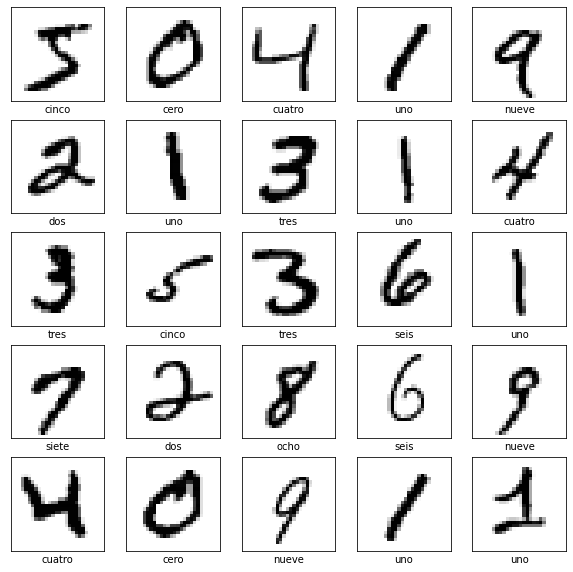

In [6]:
# Visualizamos features de entrenamiento sin estandarizar

plt.figure(figsize = (10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid('off')

    imagen = train_data[i,:,:]
    label_imagen = train_labels[i]
    nombre_imagen = class_names[ label_imagen ]    

    plt.imshow( imagen, cmap=plt.cm.binary)
    plt.xlabel(nombre_imagen)

## Codificación de features (de entrenamiento, validación y pruebas) que pasarán por el modelo:

In [7]:
# Extraemos dimensiones de features de entrenamiento, validación y de prueba
s_a = train_data.shape
s_b = validation_data.shape
s_c = test_data.shape

# Codificamos los datos de entrenamiento, validación y de prueba que pasaran por la red
# (en vez de usar arreglos 3D de 'N x P x Q', usaremos arreglos 2D de 'N x P*Q' )
x_train = train_data.reshape((s_a[0],  s_a[1]*s_a[2]))
x_validation = validation_data.reshape((s_b[0],  s_b[1]*s_b[2]))
x_test = test_data.reshape((s_c[0],  s_c[1]*s_c[2]))

# normalizamos valores (dividiendo entre el máximo '255') para que los valores esten entre 0 y 1. 
# y los pasamos al tipo 'float32'
x_train = x_train.astype('float32')/255
x_validation = x_validation.astype('float32')/255
x_test = x_test.astype('float32')/255

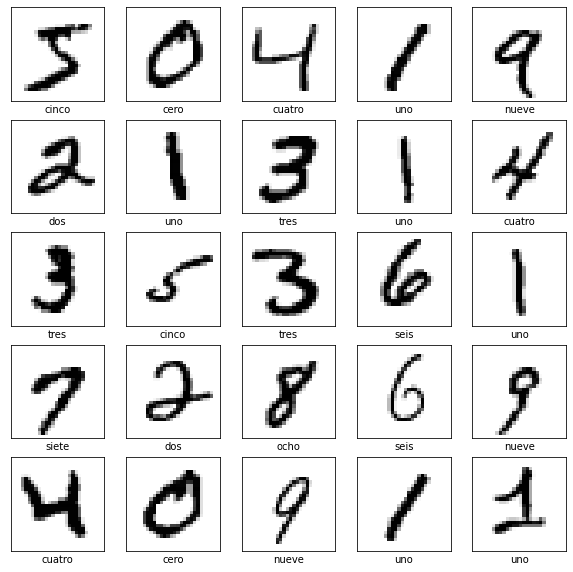

In [8]:
# Visualizamos features de entrenamiento codificados

plt.figure(figsize = (10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid('off')

    imagen = x_train[i,:].reshape(28,28)
    label_imagen = train_labels[i]
    nombre_imagen = class_names[ label_imagen ]    

    plt.imshow( imagen, cmap=plt.cm.binary)
    plt.xlabel(nombre_imagen)

In [9]:
y_train = train_labels
y_validation = validation_labels
y_test = test_labels

In [10]:
# Debido a que no usaremos los datos de validación, concatenamos los datos en un solo conjunto de pruebas:
x_test = np.concatenate((x_test, x_validation), axis=0)
y_test = np.concatenate((y_test, y_validation), axis=0)

## Inicia construcción del modelo "Random Forest":

In [11]:
# creamos el clasificador de RandomForest

# parámetros:
# n_estimators <--- numero de árboles que queremos en la red
# min_samples_split <--- número mínimo de particiones en los nodos del arbol
# min_samples_leaf  <--- número mínimo de samples que tenemos al final del árbol

n_trees=150
clasif_RF = RandomForestClassifier(n_estimators=n_trees, min_samples_split=2)

In [12]:
# Entrenamos el clasificador con los datos y etiquetas de entrenamiento:
clasif_RF.fit(x_train, y_train)

RandomForestClassifier(n_estimators=150)

### Usaremos matriz de confusión para evaluar la eficiencia del entrenamiento

In [13]:
# Una vez que el clasificador esta entrenado,
# lo aplicamos a los datos de prueba para generar etiquetas predichas:
y_test_predicted = clasif_RF.predict(x_test)
y_test_predicted.shape

(10000,)

Matriz de confusión: 
 [[ 970    0    0    0    0    2    3    1    3    1]
 [   0 1123    2    3    1    1    3    0    1    1]
 [   5    0  999    5    4    0    3    9    7    0]
 [   1    0   10  973    0    5    0    9    9    3]
 [   1    0    1    0  959    0    5    0    2   14]
 [   3    0    0   15    1  858    6    2    4    3]
 [   7    3    0    0    2    3  940    0    3    0]
 [   1    4   19    0    0    0    0  992    2   10]
 [   6    0    4    8    4    4    4    3  930   11]
 [   5    5    3   10   12    1    1    4    7  961]]


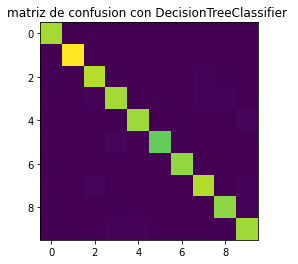

In [14]:
# Generamos matriz de confusión usando las etiquetas de prueba y etiquetas predichas:
MC_RF = confusion_matrix(y_test, y_test_predicted)
print('Matriz de confusión: \n',MC_RF)

plt.figure()
plt.imshow(MC_RF)
plt.title('matriz de confusion con DecisionTreeClassifier ')
plt.show()

In [15]:
# Calculamos el porcetaje de datos que han sido bien clasificados:

# score = (suma de elementos de la diagonal)/(suma de todos los elementos)

score_RF = ( sum(MC_RF.diagonal())/sum(sum(MC_RF)) )*100

print('\nPorcentaje de datos clasificados correctamente usando RandomForest = ', score_RF, '%')


Porcentaje de datos clasificados correctamente usando RandomForest =  97.05 %


In [16]:
clasif_RF.score(x_test, y_test)*100

97.05

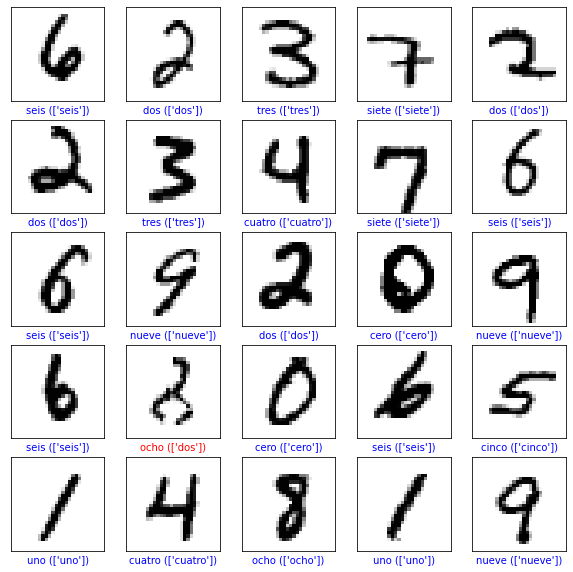

In [17]:
# Visualizamos imagenes predichas usando los datos de pruebas

plt.figure(figsize = (10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    #plt.grid('off')   

    true_label =  y_test[i]    
    aprox_label = y_test_predicted[i]

    if true_label == aprox_label:
        col = 'blue'
    else:
        col = 'red'

    imagen = x_test[i,:].reshape(28,28)
    plt.imshow(imagen, cmap=plt.cm.binary)
    plt.xlabel('{} ({})'.format( class_names[true_label], [class_names[aprox_label]]), color=col)

In [18]:
## Construccion grafica del arbol de decisiones:

#out = StringIO()
#tree.export_graphviz(clasif_RF , out_file = out)
#graph = pydotplus.graph_from_dot_data(out.getvalue())
#graph.write_png('arbol_decisiones.png')

# Guardamos el modelo entrenado para usarlo posteriormente sin tener que volver a entrenar:

In [19]:
# Importamos función para guardar el modelo entrenado:
#from sklearn.externals import joblib
import joblib

joblib.dump(clasif_RF , 'modelo_entrenado_RF_Mnist.pkl')

['modelo_entrenado_RF_Mnist.pkl']